In [1]:
from vid_utils import Video_Utils

In [2]:
%matplotlib inline

In [3]:
VIDEO_DIR = '../../video/raw'
LABEL_DIR = 'data'

In [4]:
x, y = Video_Utils.get_transformed_data(crop_height=[150,350],video_dir=VIDEO_DIR, label_dir=LABEL_DIR)

VID_20180325_143338.mp4 is good to use
fetching data/VID_20180325_143338.mp4.csv
loaded video sized 1.384128144gb
cropping...
resizing...
compressed 0 images
compressed 200 images
compressed 400 images
compressed 600 images
compressed 800 images
compressed 1000 images
compressed 1200 images
grayscaling..
done
transformed video now sized 0.061516928gb


In [5]:
x.shape

(1335, 40, 144)

In [32]:
%%writefile temporal_transformers.py

import numpy as np

class Temporal_Transformers:

    @staticmethod
    def do_all(x, y):
        print('stretching...')
        x_stretched, y_stretched = Temporal_Transformers.transform_stretch(x, y)
        print('diffing...')
        x_delta, y_delta = Temporal_Transformers.transform_to_delta(x_stretched, y_stretched)
        print('stacking...')
        x_stack, y_stack = Temporal_Transformers.transform_to_stack(x_delta, y_delta)
        print('done...')
        return x_stack, y_stack
        
        
    
    # stretch framerate (assume data is collected at 30fps)
    @staticmethod
    def transform_stretch(x, y, original_fps=30, new_fps=5):
        '''
        Increases time between frames, then stacks frames inorder to prevnt data loss.
        '''
        step_gap = int(original_fps/new_fps)
        x_stretched = np.zeros(x.shape)
        y_stretched = np.zeros(y.shape)

        prev_start = 0

        for step_start in range(step_gap):
            temp_x_stretched = x[step_start::step_gap]
            temp_y_stretched = y[step_start::step_gap]

            # print(temp_x_stretched.shape, prev_start, len(temp_x_stretched))

            slice_length = len(temp_x_stretched)

            x_stretched[prev_start : prev_start + slice_length] = temp_x_stretched
            y_stretched[prev_start : prev_start + slice_length] = temp_y_stretched
            prev_start += slice_length

        assert(len(x_stretched) == len(x))
        assert(len(x_stretched) == len(y_stretched))

        return x_stretched, y_stretched
    

    # delta images
    @staticmethod
    def transform_to_delta(x, y, thresh=0.015):
        x_delta = (x[:-1] - x[1:]) > thresh
        y_delta = y[1:]
        assert(len(x_delta)==len(y_delta))
        return x_delta, y_delta
    
    
    # image stacks
    @staticmethod
    def transform_to_stack(x, y, stack_size=5):
        new_len = len(x) - stack_size
        x_stack = np.zeros([new_len, stack_size, *x.shape[1:]])

        for i in range(new_len):
            x_stack[i] = x[i:i+stack_size]

        y_stack = y[stack_size:]

        assert(len(x_stack)==len(y_stack))

        return x_stack, y_stack

Writing temporal_transformers.py


In [15]:
temp_x, temp_y = Temporal_Transformers.do_all(x, y)

stretching...
diffing...
stacking...
done...


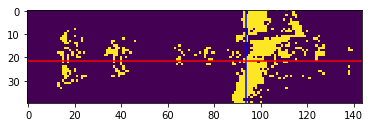

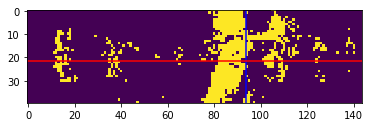

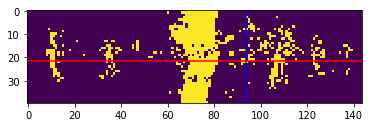

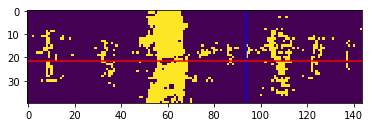

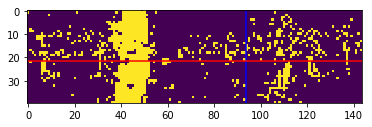

In [23]:
temp_x.shape
n = 100
for i in temp_x[n]:
    Video_Utils.display_image_with_label(i,y[n])

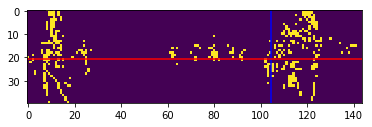

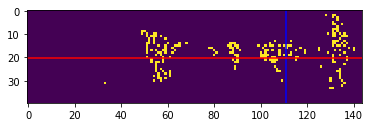

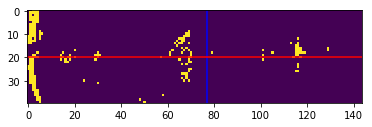

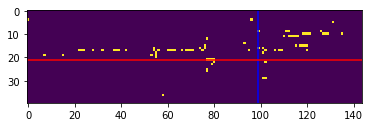

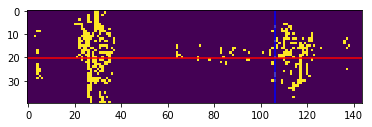

((1334, 40, 144), (1334, 2))

In [24]:
x_delta, y_delta = Temporal_Transformers.transform_to_delta(x, y)
Video_Utils.show_sample_images_with_labels(x_delta, y_delta)
x_delta.shape, y_delta.shape

In [25]:
x_stack, y_stack = Temporal_Transformers.transform_to_stack(x_delta, y_delta)

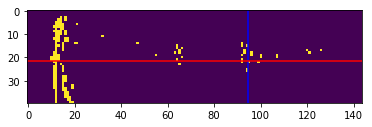

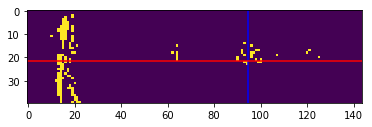

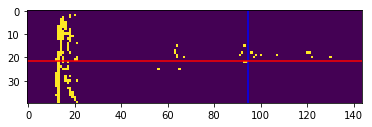

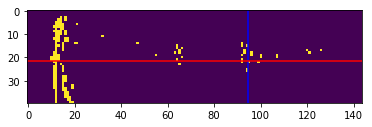

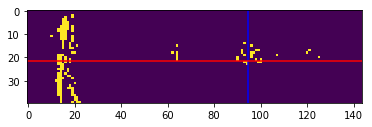

In [26]:
Video_Utils.show_sample_images_with_labels(x_stack[100], np.repeat([y_stack[100]], 5, axis=0))

In [27]:
x_stretched, y_stretched = Temporal_Transformers.transform_stretch(x, y)

In [28]:
import matplotlib.pyplot as plt

In [29]:
%matplotlib inline

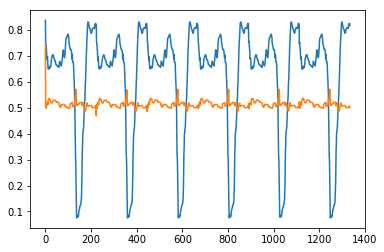

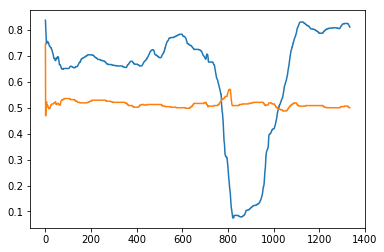

In [30]:
plt.plot(y_stretched)
plt.show()
plt.plot(y)
plt.show()